In [1]:
# importing libraries
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
main_folder = "data"

station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]
station_folders

['Cascata', 'Piratininga']

In [3]:
column_rename_dict = {
    "PM 2,5": "PM2.5",
    "Partículas Respiráveis (<2,5µm)(µg/m3)": "PM2.5",
    "Partículas Inaláveis (<10µm)(µg/m3)": "PM10",
    "Temperatura (ºC)": "Temperatura",
    "Tº": "Temperatura",
    "Radiação Solar (W/m2)": "Radiação Solar",
    "Monóxido de Carbono (ppm)": "Monóxido de Carbono",
    "CO": "Monóxido de Carbono",
    "Velocidade Escalar do Vento (m/s)": "Velocidade do Vento",
    "Direção Escalar do Vento (grau)": "Direção do Vento",
    "Umidade relativa (%)": "Umidade Relativa",
    "Precipitação Pluviométrica (mm)": "Precipitação",
    "Pressão Atmosférica (mmHg)": "Pressão Atmosférica",
    "Dióxido de enxofre (ppb)": "Dióxido de Enxofre",
    "Ozônio (ppb)": "Ozônio",
    "Monóxido de Nitrogênio (ppb)": "Monóxido de Nitrogênio",
    "Óxidos de Nitrogênio (ppb)": "Óxidos de Nitrogênio",
    "Dióxido de Nitrogênio (ppb)": "Dióxido de Nitrogênio",
    "HCT (ppm)": "HCT",
    "CH4 (ppm)": "Metano",
    "HCNM (ppm)": "HCNM",
    "Monóxido de Carbono Média Móvel (ppm)": "Monóxido de Carbono Média Móvel",
    "Data": "Data",
    "Hora": "Hora",
    "Média Horária": "Média Horária",
    "Seno da direção do vento": "Seno da Direção do Vento",
    "Cosseno da direção do vento": "Cosseno da Direção do Vento",
    "Seno ponderado": "Seno Ponderado",
    "Cosseno ponderado": "Cosseno Ponderado",
    "PM10": "PM10",
    "NO2": "Dióxido de Nitrogênio",
    "O3": "Ozônio",
    "SO2": "Dióxido de Enxofre",
    "DV": "Direção do Vento",
    "PP": "Pressão Atmosférica",
    "PA": "Precipitação",
    "VV": "Velocidade do Vento",
    "RS": "Radiação Solar",
    "UR": "Umidade Relativa"
}
import pandas as pd
import os

for station_folder in station_folders:
    dfs = []  

    base_path = os.path.join(main_folder, station_folder)
    files = [f for f in os.listdir(base_path) if f.endswith(".xlsx")]
    
    for file in files:
        year = int(file.split("_")[1].split(".")[0])
        file_path = os.path.join(base_path, file)
        df = pd.read_excel(file_path, skiprows=lambda x: x in [0, 2] if year >= 2015 else None)
        
        if year < 2015:
            if 'Data' in df.columns and 'Hora' in df.columns:
                df['Data e Hora'] = df['Data'].astype(str) + ' ' + df['Hora'].astype(str)
                df = df.drop(columns=['Data', 'Hora'])
            df['Data e Hora'] = pd.to_datetime(df['Data e Hora'], format='%d-%m-%Y %H:%M:%S', errors='coerce').dt.date
            df = df[df['Data e Hora'].notna()]
            df.set_index('Data e Hora', inplace=True)
        else:
            if 'Data e Hora' not in df.columns:
                df.rename(columns={df.columns[0]: 'Data e Hora'}, inplace=True)
            df['Data e Hora'] = pd.to_datetime(df['Data e Hora'], format='%d-%m-%Y %H:%M:%S', errors='coerce')
            df = df[df['Data e Hora'].notna()]
            df.set_index('Data e Hora', inplace=True)

        valid_columns = df.columns.intersection(column_rename_dict.keys())
        df.rename(columns={col: column_rename_dict[col] for col in valid_columns}, inplace=True)
        dfs.append(df)

    # Concatenando os DataFrames acumulados
    combined_data = pd.concat(dfs, ignore_index=False, axis=0)

    # Salvando o DataFrame combinado com a data e hora como índice
    combined_data.to_csv(f"{station_folder}_combined.csv", index=True)
    
    # Adicionando a data como uma coluna antes de salvar
    combined_data.reset_index(inplace=True)
    combined_data.rename(columns={'index': 'Data e Hora'}, inplace=True)

    # Salvando o DataFrame combinado
    combined_data.to_excel(f"{station_folder}_combined.xlsx", index=False)
    
    

C:\Users\daniel\AppData\Local\Temp\ipykernel_13220\2263770373.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat(dfs, ignore_index=False, axis=0)


          Data e Hora  Velocidade do Vento  Direção do Vento  Temperatura  \
0 2015-01-01 00:30:00                  NaN               NaN          NaN   
1 2015-01-01 01:30:00                  NaN               NaN          NaN   
2 2015-01-01 02:30:00                  NaN               NaN          NaN   
3 2015-01-01 03:30:00                  NaN               NaN          NaN   
4 2015-01-01 04:30:00                  NaN               NaN          NaN   

   Umidade Relativa Precipitação  Pressão Atmosférica  Radiação Solar  PM2.5  \
0               NaN          NaN                  NaN             NaN    NaN   
1               NaN          NaN                  NaN             NaN    NaN   
2               NaN          NaN                  NaN             NaN    NaN   
3               NaN          NaN                  NaN             NaN    NaN   
4               NaN          NaN                  NaN             NaN    NaN   

   PM10  ...  Estação.4  Estação.5  Estação.6 Estação.7 

C:\Users\daniel\AppData\Local\Temp\ipykernel_13220\2263770373.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  combined_data = pd.concat(dfs, ignore_index=False, axis=0)


          Data e Hora  Velocidade do Vento  Direção do Vento  Temperatura  \
0 2015-01-01 00:30:00                 1.18             92.23        24.17   
1 2015-01-01 01:30:00                 1.87             77.20        24.36   
2 2015-01-01 02:30:00                 2.92             68.54        23.99   
3 2015-01-01 03:30:00                 2.89             74.10        23.46   
4 2015-01-01 04:30:00                 1.66             71.08        23.12   

   Umidade Relativa Precipitação  Pressão Atmosférica  Radiação Solar  PM2.5  \
0             67.50          NaN                  0.0            2.52    NaN   
1             65.80          NaN                  0.0            1.72    NaN   
2             67.75          NaN                  0.0            1.91    NaN   
3             70.38          NaN                  0.0            1.96    NaN   
4             71.25          NaN                  0.0            1.82    NaN   

   PM10  ...  Seno da Direção do Vento  Cosseno da Direç

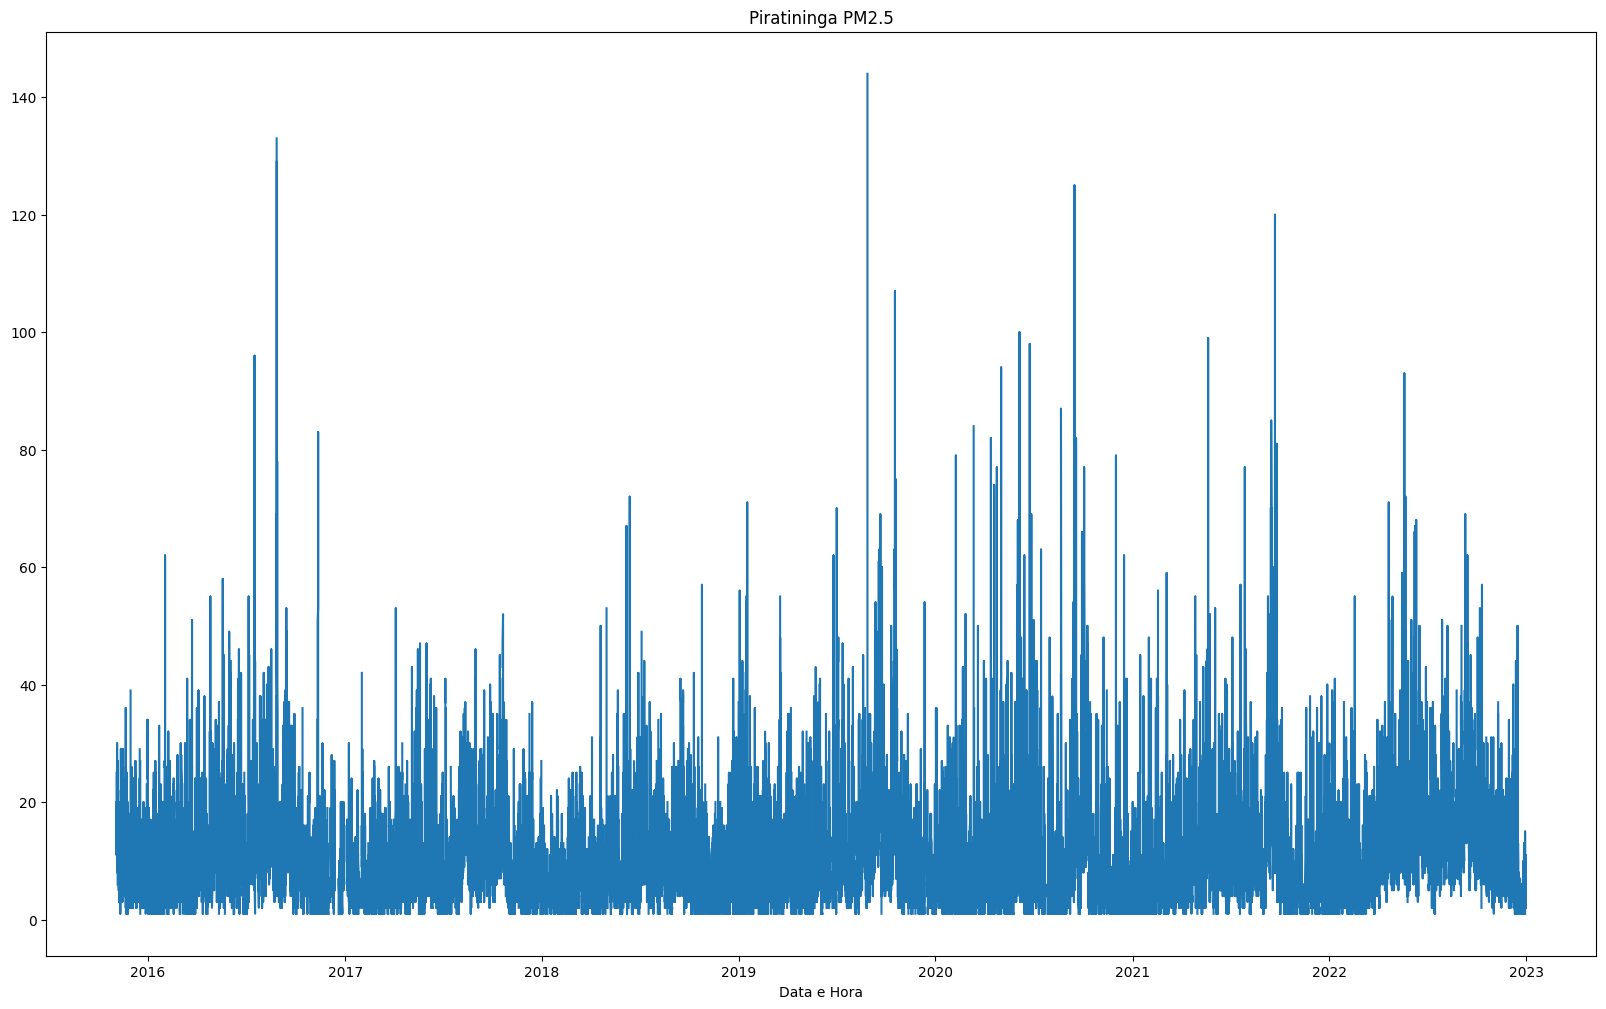

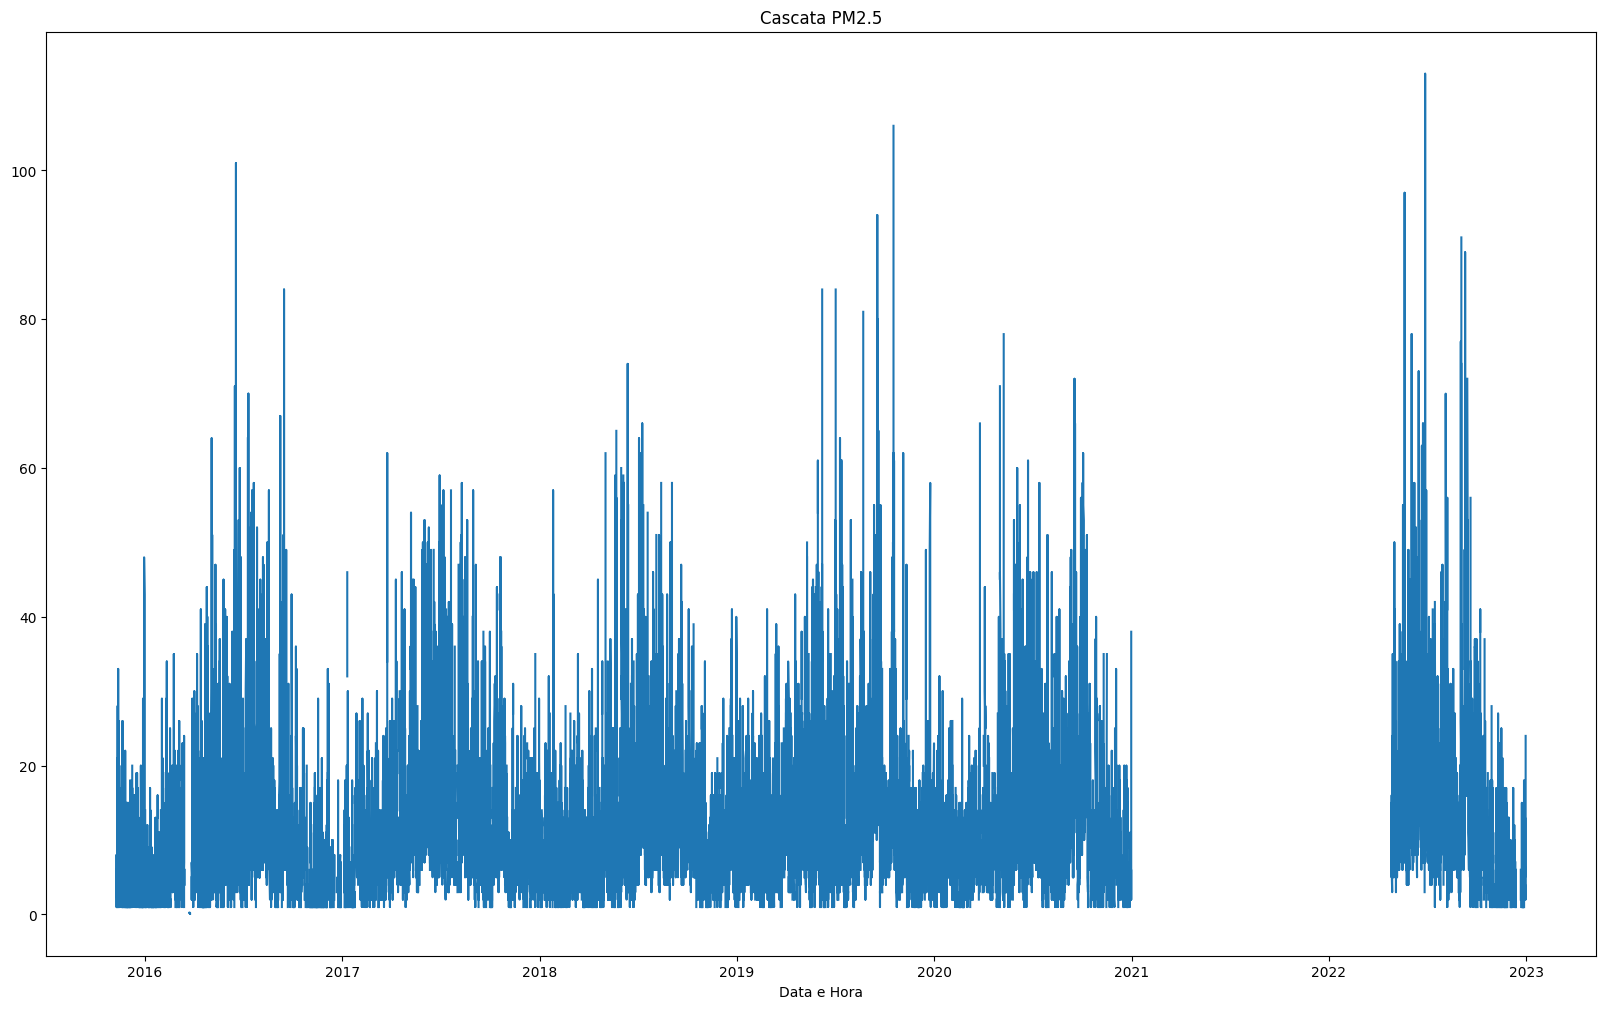

In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt

main_folder = "data"
station_folders = [f for f in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, f))]

for station_folder in reversed(station_folders):
    combined_data = pd.read_excel(f"{station_folder}_combined.xlsx")
    # Especificando o formato correto da data
    combined_data['Data e Hora'] = pd.to_datetime(combined_data['Data e Hora'], format='%Y-%m-%d %H:%M:%S', errors='coerce').dt.date
    combined_data = combined_data.set_index('Data e Hora')
    
    # Aumentando o tamanho do gráfico
    plt.figure(figsize=(20, 12))  
    
    combined_data['PM2.5'].plot()
    plt.title(f"{station_folder} PM2.5")
    plt.show()
